# Entrenamiento de redes neuronales con PyTorch

## Construcción de redes neuronales

PyTorch nos ofrece la clase tensor y las funcionalidades de autograd. Estas poderosas herramientas nos dan todo lo necesario para construir y entrenar redes neuronales artificiales.

Para facilitar aun más estas tareas PyTorch tiene módulos de alto nivel que implementan:

1. Modelo base de red neuronal: `torch.nn.Module`
1. Distintos tipos de capas, funciones de activación y funciones de costo: [`torch.nn`](https://pytorch.org/docs/stable/nn.html)
1. Distintos algoritmos de optimización basados en gradiente descedente: [`torch.optim`](https://pytorch.org/docs/stable/optim.html)

Una red neuronal en PyTorch es una clase de Python que hereda de [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Como mínimo esta clase debe implementar las funciones `__init__` y `forward`

- El constructor define las capas que se utilizaran
- Heredar de `nn.Module` hace que los parámetros de las capas queden registrados por la máquina de estado de PyTorch
- La función `forward` recibe como argumento los datos de entrada y retorna la predicción del modelo, es decir que define como se conectan las capas

:::{note}

La función `forward()` actua como la función `__call__()` de Python, es decir que se creamos una objeto `model` que herada de `nn.Module` llamar `model.forward(x)` es equivalente a `model(x)`

:::

### Capa completamente conectada

Una capa completamente conectada (*fully-connected*) también llamada capa densa, implementa la siguiente operación:

$$
z = wx + b
$$

donde $x$ son los datos que entran en la capa y $w,b$ son los parámetros (pesos y sesgos) de la capa.

Esta capa está implementada en Pytorch como [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear). El constructor de este objeto espera la dimensionalidad (número de neuronas) de entrada y salida de la capa. Por ejemplo para crear una capa con tres entradas y dos salidas utilizaríamos:

In [1]:
import torch
import torch.nn as nn

dense = torch.nn.Linear(3, 2)

dense.weight, dense.bias

(Parameter containing:
 tensor([[ 0.1703, -0.4679, -0.2857],
         [ 0.0995, -0.0204, -0.0667]], requires_grad=True),
 Parameter containing:
 tensor([ 0.4130, -0.4899], requires_grad=True))

Una vez creada la podemos evaluar con `dense(data)` o `dense.forward(data)`:

In [2]:
dense(torch.Tensor([0, 0, 0]))

tensor([ 0.4130, -0.4899], grad_fn=<AddBackward0>)

:::{note}

Las capas son a su vez instancias de `torch.nn.Module`. Es decir que un módulo puede tener otros módulos anidados.

:::

### Funciones de activación 

Las funciones de activación más comunes de la literatura están implementadas como clases en [`torch.nn`](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

Veamos algunos ejemplos para aprender a utilizarlas:

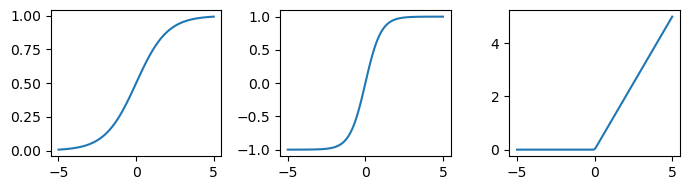

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

data = torch.linspace(-5, 5, steps=100)
activations = [nn.Sigmoid(), nn.Tanh(), nn.ReLU()]

fig, ax = plt.subplots(1, len(activations), figsize=(7, 2), tight_layout=True)
for activation, ax_ in zip(activations, ax):
    ax_.plot(data, activation(data))

### Perceptrón multicapa (MLP) en Pytorch

Considerando lo anteriormente mencionado la implementación de un perceptrón multicapa (multilayer perceptron) con una capa oculta y función de activación sigmoide en PyTorch sería:

In [4]:
import torch
import torch.nn as nn

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim): 
        super(type(self), self).__init__()  
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

Crear una capa `Linear` hace que se registren sus parámetros `weight` y `bias` en el grafo. Inicialmente los parámetros tienen valores aleatorios

In [5]:
model = MultiLayerPerceptron(input_dim=2, output_dim=1, hidden_dim=2)

model.hidden.weight, model.hidden.bias, model.output.weight, model.output.bias

(Parameter containing:
 tensor([[-0.3532, -0.6750],
         [ 0.2961, -0.6165]], requires_grad=True),
 Parameter containing:
 tensor([-0.6416, -0.3000], requires_grad=True),
 Parameter containing:
 tensor([[-0.5612, -0.6022]], requires_grad=True),
 Parameter containing:
 tensor([-0.3252], requires_grad=True))

PyTorch también admite una forma "más funcional" de crear modelos utilizando [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#sequential).

El modelo anterior sería:

In [6]:
model = nn.Sequential(nn.Linear(2, 2),
                      nn.Sigmoid(),
                      nn.Linear(2, 1))

Esta forma de crear modelos es más concisa pero menos reutilizable.

## Funciones de costo y optimizadores

Para entrenar una red neuronal debemos definir 

1. Una función de costo: Aquello que vamos a minimizar
1. Un algoritmo de optimización: De que forma vamos a minimizar

Las funciones de costo típicas están implementadas como clases en el módulo [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). Por ejemplo la clase [`MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) representa el error cuadrático medio, que se define como:

$$
\mathcal{L}(y, \hat y) = \sum_{d=1}^D ( y_d - \hat y_d)^2
$$

donde $y$ es la etiqueta (vector con D dimensiones) e $\hat y$ es la predicción del modelo.

:::{note}

El MSE se utiliza en problemas de regresión (etiqueta con valores reales). Cuando entrenamos con esta función de costo debemos asegurarnos de que el modelo tenga tantas unidades de salida como dimensiones tenga la etiqueta.

:::

La clase [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) representa la entropía cruzada, que se define como:

$$
\mathcal{L}(y, \hat y) = - \sum_{c=1}^C  y_c \log (\hat y_c )
$$

donde $y_c \in \{0,1\}$, $\hat y_c \in [0,1]$ y $\sum_{c=1}^C \hat y_c = 1$.

:::{note}

Esta función de costo se utiliza en problemas de clasificación de $C$ clases. Cuando entrenamos con esta función de costo debemos asegurarnos de que el modelo tenga tantas unidades de salida como clases tenga el problema.  

:::

:::{warning}

La implementación de entropía cruzada de torch espera que las etiquetas $y$ estén en formato **categórico**, es decir como un entero con valor $0, 1, 2, \ldots, C-1$. Adicionalmente espera que las predicciones $\hat y$ estén en formato **logits** (números reales pre-activados).

:::

Luego de crear una instancia de estas clases las podemos llamar cpmo una función. Por ejemplo si queremos calcular el error medio cuadrático entre dos tensores:

```python
criterion = torch.nn.MSELoss(reduction='mean')
loss = criterion(output, target)
```

:::{note}

También podemos crear nuestra propia función de costo. Por ejemplo podríamos lograr lo mismo que `MSELoss` habiendo definido `criterion = lambda ypred, y : (y-ypred).pow(2).mean()`

:::

Los algoritmos de optimización están implementados en el módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html). Hoy en día los más utilizados son:

| Optimizador | Descripción |
| ---- | ---- |
| [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) | Gradiente descedente estocástico con momentum|
| [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) | Gradiente descedente con tasa de aprendizaje adaptiva |


Para crear un objeto optimizador debemos entregar como argumento los parámetros del modelo y las argumentos específicos del optimizador. Por ejemplo para SGD:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0, weight_decay=0)
```

donde:

- `lr` Es la tasa de aprendizaje. Debe ser un valor pequeño para no desestabilizar el entrenamiento, pero no tan pequeño para enlentencerlo demasiado
- `momentum` es la tasa de momentum. Podemos utilizar un valor mayor que cero para evitar estancamiento en mínimos locales
- `weight_decay` controla la regularización (norma L2) de los parámetros. Podemos utilizar un valor mayor que cero para evitar sobreajuste 

Una vez creado podemos llamar su función principal `step()` la cual realiza una actualización de parámetros de acuerdo a las derivadas calculadas con `loss.backward()`.

## Ajustando un modelo paso a paso

Consideremos el siguiente dataset $X$ con etiqueta $Y$. El dataset tiene cuatro ejemplos separados en dos clases. Los ejemplos tienen cada uno dos atributos.

In [7]:
X = torch.tensor([[-1.0, -1.0],
                  [-1.0, 1.0],
                  [1.0, -1.0],
                  [1.0, 1.0]])

Y = torch.tensor([0, 0, 0, 1])

n_features, n_classes = X.shape[1], len(Y.unique())

Utilizaremos `CrossEntropyLoss` para entrenar por lo tanto consideramos dos unidades de salida en la última capa.

In [8]:
n_hidden = 3
model = nn.Sequential(nn.Linear(n_features, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_classes))

criterion = torch.nn.CrossEntropyLoss(reduction='sum')

model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=3, out_features=2, bias=True)
)

Como optimizador utilizaremos Adam:

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Primero realizamos una predicción (inferencia) con:

In [10]:
hatY = model(X)
hatY

tensor([[-0.0495,  0.5699],
        [ 0.1917,  0.6147],
        [-0.0600,  0.4073],
        [ 0.1669,  0.4399]], grad_fn=<AddmmBackward0>)

Luego calculamos la función de pérdida:

In [11]:
loss = criterion(hatY, Y)
loss

tensor(3.4967, grad_fn=<NllLossBackward0>)

En seguida calculamos el gradiente de la función de pérdida:

In [12]:
loss.backward()

Los gradientes se guardan en el atributo `grad` de todos los pesos y sesgos (parámetros) de la red:

In [13]:
model[0].weight.grad, model[0].bias.grad

(tensor([[0.0197, 0.0147],
         [0.1103, 0.1128],
         [0.0111, 0.0088]]),
 tensor([-0.0283, -0.1992, -0.0116]))

Finalmente actualizamos los parámetros usando la función `step` de nuestro optimizador

Los parámetros actuales de la primera capa son:

In [14]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.7040,  0.2434],
         [ 0.5366,  0.6847],
         [-0.6445,  0.3375]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5884, -0.0226, -0.2966], requires_grad=True))

In [15]:
optimizer.step()

Los parámetros luego de hacer la actualización son:

In [16]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.6940,  0.2334],
         [ 0.5266,  0.6747],
         [-0.6545,  0.3275]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5984, -0.0126, -0.2866], requires_grad=True))

:::{tip}

Para interpretar la salida de la red como probabilidades podemos aplicar una activación `nn.Softmax(dim=1)` como se muestra a continuación. 

:::

In [17]:
nn.Softmax(dim=1)(hatY).detach()

tensor([[0.3499, 0.6501],
        [0.3958, 0.6042],
        [0.3853, 0.6147],
        [0.4322, 0.5678]])

:::{note}

Cada columna representa a una clase y cada fila a un ejemplo. Los valores están siempre entre cero y uno, y además las filas suman uno.

:::

En general el proceso de ajuste se realiza iterativamente durante un cierto número de pasos o "épocas" de entrenamiento, tal como se muestra a continuación:

In [18]:
for nepoch in range(1000):
    hatY = model.forward(X)
    optimizer.zero_grad()
    loss = criterion(hatY, Y)
    loss.backward()
    optimizer.step()
    if nepoch % 100 == 0:
        print(f"{nepoch} {loss.item():0.2f} {torch.nn.Softmax(dim=1)(hatY)[:, 1].detach()}")

0 3.43 tensor([0.6393, 0.5906, 0.6028, 0.5537])
100 1.38 tensor([0.0801, 0.1442, 0.2093, 0.4026])
200 0.52 tensor([0.0110, 0.0650, 0.0681, 0.6931])
300 0.22 tensor([0.0031, 0.0271, 0.0289, 0.8481])
400 0.12 tensor([0.0014, 0.0140, 0.0156, 0.9118])
500 0.08 tensor([8.5396e-04, 8.5738e-03, 9.7344e-03, 9.4210e-01])
600 0.06 tensor([5.7724e-04, 5.8299e-03, 6.6357e-03, 9.5879e-01])
700 0.04 tensor([4.2245e-04, 4.2423e-03, 4.8179e-03, 9.6900e-01])
800 0.03 tensor([3.2588e-04, 3.2357e-03, 3.6612e-03, 9.7575e-01])
900 0.03 tensor([2.6089e-04, 2.5543e-03, 2.8788e-03, 9.8046e-01])


:::{note}

Paso a paso, el error (función de costo) disminuye y la predicción del modelo se acerca a la etiqueta

:::

## Entrenamiento por minibatches

Si el *dataset* del problema es de gran tamaño no es conveniente utilizar el conjunto completo para calcular la función de costo y derivar. En general actualizamos el modelo presentándole subconjuntos (*minibatches*) del dataset.

:::{note}

Esto es lo que se conoce como la estimación estocástica del gradiente descedente (stochastic gradient descent, SGD).

:::

A continuación veremos algunas clases de PyTorch que facilitan la interacción entre el modelo y el conjunto de entrenamiento. A modo de ejemplo crearemos un conjunto de datos sintético con dos atributos, dos clases y que no es linealmente separable:

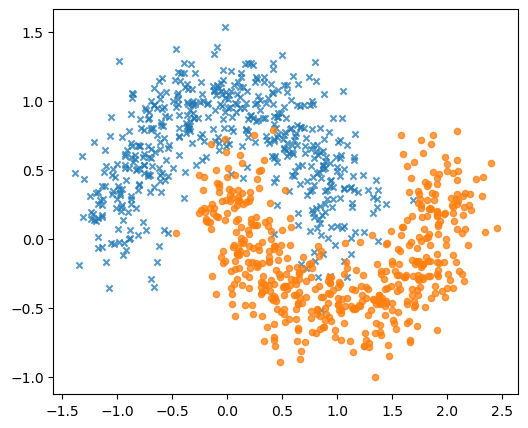

In [19]:
import numpy as np
import sklearn.datasets

np.random.seed(0)
X, y = sklearn.datasets.make_moons(n_samples=1000, noise=0.2)

fig, ax = plt.subplots(figsize=(6, 5))
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], s=20, marker=marker, alpha=0.75)

El súbmodulo [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) tiene los objetos que facilitan la interacción con datos. Sus clases principales son:

- [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset): Clase abstracta que representa a un conjunto de datos
- [`Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset): Clase que representa una partición de un conjunto de datos, por ejemplo la partición de entrenamiento o validación
- [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset): Generador que recibe un conjunto de datos y retorna subconjuntos (minibatches) iterativamente


El primer paso es crear una clase que represente nuestro conjunto de datos en particular, esta clase debe heredar de `Dataset` y debe implementar las funciones `__len__` y `__getitem__`:

In [20]:
import torch.utils.data as data

class MyDataset(data.Dataset):
    
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = torch.from_numpy(data.astype('float32'))
        self.labels = torch.from_numpy(labels.astype('int'))
        
    def __getitem__(self, idx: int):
        return (self.data[idx], self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    
dataset = MyDataset(X, y)

dataset[0], len(dataset)

((tensor([2.0861, 0.5740]), tensor(1)), 1000)

donde

- El constructor recibe los datos y los convierte en formato tensor
- `__getitem__`, recibe un índice y retorna una tupla (dato, etiqueta)
- `__len__` retorna la cantidad de ejemplos del conjunto de datos

Para crear particiones de este dataset podemos utilizar la función `random_split` del módulo `data`. Esta función recibe el dataset, los tamaños de cada partición y una semilla aleatoria:

In [21]:
train_set, valid_set, test_set = data.random_split(dataset, [600, 200, 200], 
                                                   generator=torch.Generator().manual_seed(1234))

Finalmente creamos objetos `DataLoader` para obtener minibatches de entrenamiento, validación y prueba con:

In [22]:
train_loader = data.DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = data.DataLoader(valid_set, shuffle=False, batch_size=128)
test_loader = data.DataLoader(test_set, shuffle=False, batch_size=128)

Los argumentos principales de esta clase son:

- Un objeto `Dataset` o `Subset`
- `shuffle`: Booleano que índica si los ejemplos se muestran de forma ordenada o desordenada
- `batch_size`: Entero que indica la cantidad de ejemplos por *minibatch*

:::{important}

Es conveniente presentar el conjunto de entrenamiento en distinto orden en cada época. Utilice `shuffle=True` para este conjunto. 

:::

Una vez creado el objeto `DataLoader` se puede ocupar de forma equivalente a otros iteradores de Python:

In [23]:
for batchx, batchy in train_loader:
    break
    
batchx.T, batchy

(tensor([[ 0.2742,  0.0838,  0.3535,  1.0220,  0.5325,  0.9625, -0.1301,  0.7547,
           0.4513,  0.4570, -0.7164, -0.3492,  0.9425,  0.7684,  0.0605, -0.3334,
           0.0351,  0.2826, -0.1815,  0.4193,  1.3026, -0.3905, -1.2129,  0.4229,
           0.8711, -0.9832, -0.2609, -0.3761, -0.2786,  0.2538,  0.7121, -0.7011],
         [ 1.1606,  0.0487,  0.7483,  0.5886, -0.3438,  0.2852,  0.1867,  0.3459,
           0.2463, -0.5059,  0.8689,  0.7954,  0.4273, -0.6735, -0.0425,  0.9329,
          -0.2298, -0.0536,  0.9742, -0.4464, -0.5140,  0.2952,  0.6996,  0.8891,
           0.5274, -0.0205,  0.8748,  0.8369,  0.5381,  0.7022,  0.6715,  0.4590]]),
 tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

## Esquema general de entrenamiento en PyTorch

Habiendo definido el modelo, el criterio, el optimizador y los datos, el esquema general de entrenamiento de un modelo en PyTorch sería:

``` python
for epoch in range(num_epochs): # Durante un cierto número de épocas
    for minibatch in data: # Para cada minibatch de datos
        optimizer.zero_grad() # Limpiamos los gradientes
        x, y = minibatch # Desempaquetamos
        yhat = model.forward(x) # Predecimos
        loss = criterion(yhat, y) # Evaluamos
        loss.backward() # Calculamos los gradientes
        optimizer.step() # Actualizamos los parámetros
```

donde

- Una época es una presentación completa del conjunto de entrenamiento
- Un *minibatch* es un subconjunto del conjunto de entrenamiento


Adicionalmente, debemos considerar un bucle de validación donde sólo realizamos predicción y evaluación de la *loss* con el objetivo de detectar sobre-ajuste

Early Stopping
: Detención del entrenamiento cuando la loss de validación no haya disminuido durante una cierta cantidad de épocas (paciencia). Se utiliza para evitar el sobreajuste

:::{important}

En cada época, verifique si el error de validación ha alcanzado un nuevo mínimo. Si es así guarde un respaldo del modelo utilizado [`torch.save`](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

:::

A continuaciones se ponen en práctica estos criterios utilizando PyTorch. Por conveniencia se implementan las siguientes funciones:

- `update_step`: Recibe un minibatch  y actualiza los parámetros
- `evaluation_step`: Recibe un minibtach y evalúa el criterio de optimización
- `train_one_epoch`: Realiza una época de entrenamiento. Se encarga de guardar el modelo si es el mejor encontrado hasta ese punto


In [24]:
def update_step(data, label):
    prediction = model(data)
    optimizer.zero_grad()
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_step(data, label):
    prediction = model(data)
    loss = criterion(prediction, label)
    return loss.item()

def train_one_epoch(epoch):    
    train_loss, valid_loss = 0.0, 0.0    
    for batchx, batchy in train_loader:
        train_loss += update_step(batchx, batchy)    
    for batchx, batchy in valid_loader:
        valid_loss += evaluate_step(batchx, batchy)
        
    # Guardar modelo si es el mejor hasta ahora
    global best_valid_loss
    if epoch % 10 == 0:
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({'epoca': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, 
                       'best_model.pt')
    
    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)

:::{note}

Para entrenar en GPU sería necesario 

- que el modelo esté en memoría de GPU 
- enviar los datos y etiquetas a GPU antes de realizar los cálculos. 

:::


En este caso el modelo se entrena por 500 épocas

CPU times: user 4min 3s, sys: 362 ms, total: 4min 3s
Wall time: 1min 1s


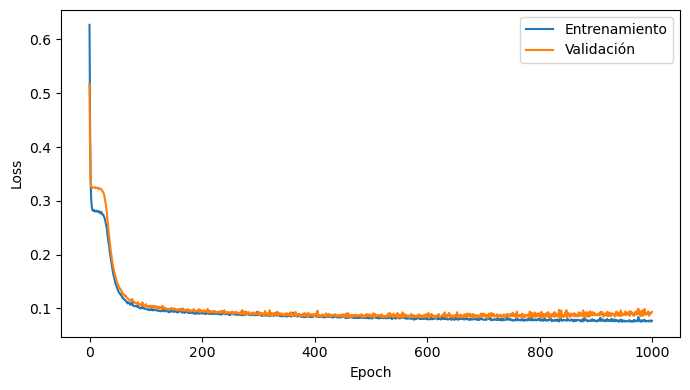

In [25]:
%%time

def my_model(n_hidden: int):
    return nn.Sequential(nn.Linear(2, n_hidden), nn.Tanh(), nn.Linear(n_hidden, 2))

model = my_model(5)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

max_epochs, best_valid_loss = 1000, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))

for epoch in range(max_epochs):
    running_loss[epoch] = train_one_epoch(epoch)
    
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

Cargamos la información serializada del modelo utilizado `torch.load`

In [26]:
saved_model = torch.load('best_model.pt')

El mejor modelo se obtuvo en la época

In [27]:
saved_model['epoca']

520

Podemos asignar los mejores parámetros al modelo anterior con:

In [28]:
model = my_model(5)
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

Podemos evaluar el mejor modelo en el conjunto de test para analizar su capacidad de generalización

In [29]:
from sklearn.metrics import classification_report

ytrue, ypred = [], []
for x, y_ in test_loader:
    ypred.append(nn.Softmax(dim=1)(model(x)).detach().argmax(dim=1))
    ytrue.append(y_)
ytrue, ypred = np.concatenate(ytrue), np.concatenate(ypred)

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       104
           1       0.96      0.96      0.96        96

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



En este caso también podemos visualizar el resultado de predicción en el espacio de características:

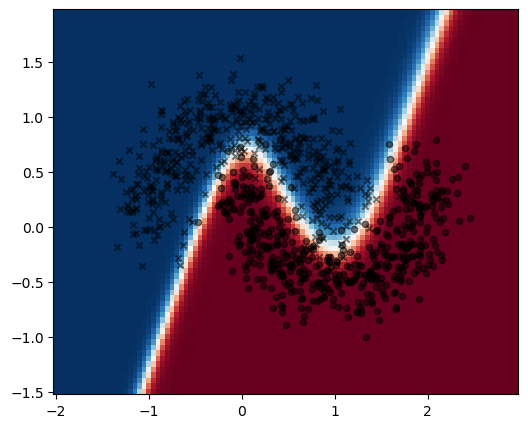

In [30]:
x1_test = np.arange(-2, 3, 0.05, dtype=np.float32)
x2_test = np.arange(-1.5, 2, 0.05, dtype=np.float32)
xx1_test, xx2_test = np.meshgrid(x1_test, x2_test)
x_test = torch.from_numpy(np.stack((xx1_test.ravel(), xx2_test.ravel())).T)

prob_test = nn.Softmax(dim=1)(model(x_test)).detach()[:, 1].reshape(xx1_test.shape)

fig, ax = plt.subplots(figsize=(6, 5))
ax.pcolormesh(x1_test, x2_test, prob_test, cmap=plt.cm.RdBu_r)
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], c='k', s=20, marker=marker, alpha=0.5)

El resultado en la capa de salida tiene forma no lineal. Sin embargo, si inspeccionemos la salida de la capa oculta, que en este caso tiene 5 neuronas:

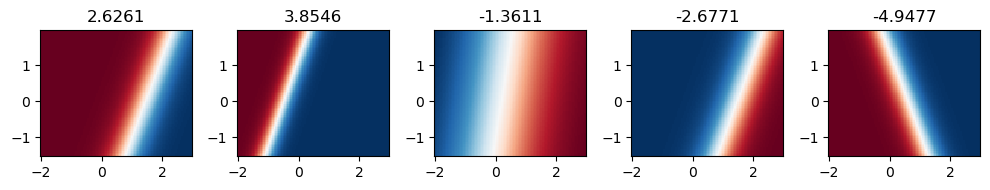

In [31]:
fig, ax = plt.subplots(1, 5, figsize=(10, 2), tight_layout=True)

for ax_, layer, w in zip(ax.ravel(), model[0](x_test).T, model[2].weight.detach()[0]):
    ax_.pcolormesh(xx1_test, xx2_test, 
                   nn.Tanh()(layer).reshape(xx1_test.shape).detach(), 
                   cmap=plt.cm.RdBu_r)
    ax_.set_title(f"{w.item():0.4f}")

:::{note}

La capa de salida combina los hiperplanos de la capa oculta. Sobre cada neurona oculta se muestra su peso en la capa de salida. Mientras más cercano a cero, menos relevante es su aporte.

:::

## Diagnósticos a partir de curvas de aprendizaje

Podemos diagnosticar el entrenamiento observando la evolución de la función de costo .

:::{important}

Siempre visualice la loss en ambos conjuntos: entrenamiento y validación.

:::

Veamos algunos casos.

**Ambas curvas en descenso**

Si las curvas se ven así:

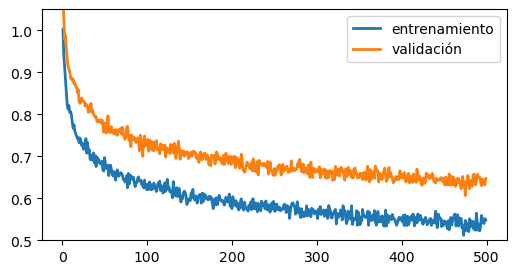

In [32]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

En este caso deberías continuar con el entrenamiento, pues no hay señal de convergencia

**Sobreajuste temprano**

Si las curvas se ven así:

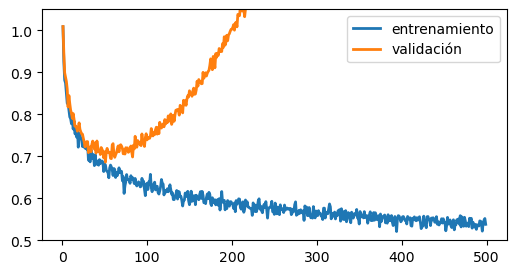

In [33]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.00001*(epochs)**2 +0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

Significa que tu modelo se ha sobreajustado. Considere las siguientes opciones:

- Implementar un modelo más sencillo, por ejemplo disminuyendo la cantidad de neuronas en la capa oculta.
- Conseguir más datos de entrenamiento
- Incorporar regularización, por ejemplo *weight decay*

**Error en el código o mal punto de partida**

Si tus curvas se ven así:

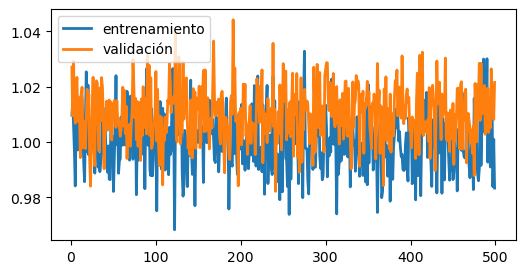

In [34]:
epochs = np.arange(1, 500)
loss_train = 1.0 + 0.01*np.random.randn(len(epochs))
loss_valid = 1.0 + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
#ax.set_ylim([0.5, 1.05])
plt.legend();

Revice que su código no tenga *bugs*. Algunas causas comunes de error son:

- el modelo no esté recibiendo adecuadamente los datos y/o la etiqueta 
- los datos tiene un rango muy grande y los gradientes explotan: normalice o reescale los datos
- la función de costo no es la adecuada para el problema 
- la tasa de aprendizaje es demasiado alta

También puede deberse a una muy mala inicialización aleatoria, reinicia el entrenamiento para comprobar si es el caso.